In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import re
import os
import patsy

from matplotlib.colors import ListedColormap

import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from esda.adbscan import ADBSCAN
from pysal.model import mgwr
from mgwr.sel_bw import Sel_BW

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

In [2]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

In [3]:
tfont = {'fontname':'Liberation Sans Narrow', 'horizontalalignment':'left'}
import math
from geopandas import GeoDataFrame
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
import mcdm

In [59]:
#加载数据
fs_area=gpd.read_file('final_output/fs/fs_area_withindex.shp',encoding="utf-8")
fs_station=gpd.read_file('final_output/fs/fs_station_withindex.shp',encoding="utf-8")
subway_grid=gpd.read_file('metro_data/mobile_grid/grid_subway_catchmentarea.shp',encoding="utf-8")
subway_flow=pd.read_csv('metro_data/mobile_grid/20190624.csv',low_memory=False,encoding="utf-8")

In [12]:
#提取站点area的grid
subway_grid2=subway_grid.copy()
subway_grid2.to_crs('EPSG:4326',inplace=True)

In [14]:
test = gpd.sjoin(subway_grid2, fs_area, how='left')

In [19]:
test.dropna(subset = ["id"], inplace=True)

In [30]:
test.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 526 entries, 7304 to 8096
Data columns (total 38 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   OBJECTID     526 non-null    int64   
 1   Id           526 non-null    int64   
 2   Tid          526 non-null    int64   
 3   Province     526 non-null    object  
 4   Zone         526 non-null    object  
 5   Shape_Leng   526 non-null    float64 
 6   Shape_Area   526 non-null    float64 
 7   geometry     526 non-null    geometry
 8   index_right  526 non-null    float64 
 9   id           526 non-null    float64 
 10  P_pop_sum    526 non-null    float64 
 11  road_lengt   526 non-null    float64 
 12  line_name    526 non-null    object  
 13  station_na   526 non-null    object  
 14  lng          526 non-null    float64 
 15  time         526 non-null    float64 
 16  area         526 non-null    float64 
 17  lat          526 non-null    float64 
 18  lng84        526 n

In [62]:
#加载人流
subway_flow_69 = subway_flow[subway_flow["time"].isin([6, 9])]

In [63]:
subway_flow_69 = subway_flow_69.groupby(['o_grid','d_grid'])['num_total'].agg(flow_day_sum='sum').reset_index()

In [64]:
subway_flow_O=subway_flow_69.copy()
subway_flow_O.rename(columns={'flow_day_sum':'O_flow','o_grid':'Tid'},inplace=True)

In [65]:
test1=pd.merge(test,subway_flow_O,on='Tid',how='left')

In [66]:
test_sub=test[['Tid']]

In [67]:
test_sub.rename(columns={'Tid':'d_grid'},inplace=True)

/opt/conda/envs/sds2020/lib/python3.7/site-packages/pandas/core/frame.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [68]:
test2=pd.merge(test1,test_sub,on='d_grid',how='right')

In [69]:
O_fs_flow = test2.groupby(['id'])['O_flow'].agg(O_flw='sum').reset_index()
fs_area=pd.merge(fs_area,O_fs_flow,on='id',how='left')

In [70]:
subway_flow_D=subway_flow_69.copy()
subway_flow_D.rename(columns={'flow_day_sum':'D_flow','d_grid':'Tid'},inplace=True)
test1=pd.merge(test,subway_flow_D,on='Tid',how='left')
test_sub=test[['Tid']]
test_sub.rename(columns={'Tid':'o_grid'},inplace=True)

In [71]:
test2=pd.merge(test1,test_sub,on='o_grid',how='right')
D_fs_flow = test2.groupby(['id'])['D_flow'].agg(D_flw='sum').reset_index()
fs_area=pd.merge(fs_area,D_fs_flow,on='id',how='left')

In [74]:
fs_area.sum(axis = 0, skipna = True)
##该时段流动的总人口37638

id                                                          325
P_pop_sum                                               1271878
road_lengt                                       1,030,933.2548
line_name     ???(??--???)???(??--???)???(??--???)???(??--??...
station_na    ??????????????????????????????????????????????...
lng                                                  2,829.5083
time                                                        375
area                                            59,965,549.1670
lat                                                    575.9091
lng84                                                2,829.3728
lat84                                                  575.9745
N_busStop_                                                 4411
N_Service_                                                   27
N_busline_                                              56.7652
N_external                                               8.2217
S_internal                              

In [75]:
fs_area['centricity_index']=(fs_area.D_flw-fs_area.O_flw)/37638

In [79]:
###计算functional polycentricity
subway_flow_O=subway_flow_69.copy()
subway_flow_O.rename(columns={'flow_day_sum':'O_flow','o_grid':'Tid'},inplace=True)
temp1=pd.merge(test,subway_flow_O,on='Tid',how='left')
temp_sub=test[['Tid','id']]
temp_sub.rename(columns={'Tid':'d_grid','id':'D_id'},inplace=True)

/opt/conda/envs/sds2020/lib/python3.7/site-packages/pandas/core/frame.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [80]:
fs_within_flow=pd.merge(temp1,temp_sub,on='d_grid',how='right')

In [83]:
fs_flow = fs_within_flow.groupby(['id','D_id'])['O_flow'].agg(flw='sum').reset_index()

In [84]:
fs_flow

,id,D_id,flw
0,1.0000,1.0000,78.0000
1,1.0000,2.0000,113.0000
2,1.0000,3.0000,85.0000
3,1.0000,4.0000,38.0000
4,1.0000,5.0000,16.0000
...,...,...,...
579,25.0000,21.0000,10.0000
580,25.0000,22.0000,6.0000
581,25.0000,23.0000,35.0000
582,25.0000,24.0000,39.0000


In [86]:
pip install networkx

Note: you may need to restart the kernel to use updated packages.


In [90]:
import networkx as nx
G_fs = nx.Graph()
G_fs = nx.from_pandas_edgelist(fs_flow, 'id', 'D_id',['flw'],create_using=nx.DiGraph)

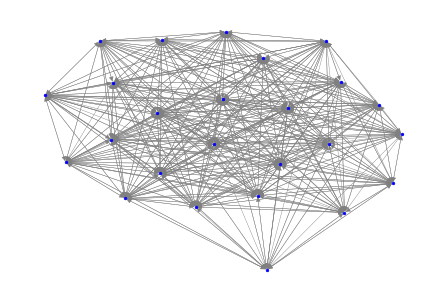

In [91]:
nx.draw(G_fs,
        node_color='b',
        node_size=8,
        edge_color='gray',
        width=0.4)

In [95]:
list(G_fs.edges(data = True))[0:50]

[(1.0, 1.0, {'flw': 78.0}),
 (1.0, 2.0, {'flw': 113.0}),
 (1.0, 3.0, {'flw': 85.0}),
 (1.0, 4.0, {'flw': 38.0}),
 (1.0, 5.0, {'flw': 16.0}),
 (1.0, 6.0, {'flw': 4.0}),
 (1.0, 7.0, {'flw': 8.0}),
 (1.0, 8.0, {'flw': 4.0}),
 (1.0, 9.0, {'flw': 2.0}),
 (1.0, 10.0, {'flw': 3.0}),
 (1.0, 11.0, {'flw': 2.0}),
 (1.0, 13.0, {'flw': 1.0}),
 (1.0, 14.0, {'flw': 1.0}),
 (1.0, 15.0, {'flw': 2.0}),
 (1.0, 16.0, {'flw': 2.0}),
 (1.0, 17.0, {'flw': 2.0}),
 (1.0, 18.0, {'flw': 3.0}),
 (1.0, 19.0, {'flw': 1.0}),
 (1.0, 20.0, {'flw': 1.0}),
 (1.0, 21.0, {'flw': 2.0}),
 (1.0, 22.0, {'flw': 2.0}),
 (1.0, 24.0, {'flw': 1.0}),
 (1.0, 25.0, {'flw': 1.0}),
 (2.0, 1.0, {'flw': 101.0}),
 (2.0, 2.0, {'flw': 264.0}),
 (2.0, 3.0, {'flw': 226.0}),
 (2.0, 4.0, {'flw': 136.0}),
 (2.0, 5.0, {'flw': 106.0}),
 (2.0, 6.0, {'flw': 16.0}),
 (2.0, 7.0, {'flw': 24.0}),
 (2.0, 8.0, {'flw': 13.0}),
 (2.0, 9.0, {'flw': 10.0}),
 (2.0, 10.0, {'flw': 8.0}),
 (2.0, 11.0, {'flw': 2.0}),
 (2.0, 12.0, {'flw': 2.0}),
 (2.0, 13.0, {'flw

In [ ]:
list(g_shp.nodes(data=True))[0:10]

In [97]:
#degree for each node
deg=nx.degree(G_fs,weight='flw')
deg

DiDegreeView({1.0: 678.0, 2.0: 1918.0, 3.0: 2076.0, 4.0: 2206.0, 5.0: 2324.0, 6.0: 1031.0, 7.0: 1526.0, 8.0: 1072.0, 9.0: 962.0, 10.0: 1042.0, 11.0: 2194.0, 13.0: 3339.0, 14.0: 4246.0, 15.0: 5201.0, 16.0: 5691.0, 17.0: 7729.0, 18.0: 7766.0, 19.0: 7502.0, 20.0: 4650.0, 21.0: 3969.0, 22.0: 2513.0, 24.0: 713.0, 25.0: 462.0, 12.0: 3731.0, 23.0: 735.0})

In [102]:
fs_den=nx.density(G_fs)

In [99]:
fs_degree = pd.DataFrame(dict(
    DEGREE = dict(deg)))

In [101]:
fs_degree['id']=fs_degree.index.values
fs_area=pd.merge(fs_area,fs_degree,on='id',how='left')

In [103]:
fs_area.head()

,id,P_pop_sum,road_lengt,line_name,station_na,lng,time,area,lat,lng84,...,C_building,Node_index,Place_inde,Settlement,Container_,geometry,O_flw,D_flw,centricity_index,DEGREE
0,1,30533,"24,402.7133",???(??--???),??,113.3186,15,"1,851,542.4230",23.0548,113.3131,...,"5,166,524,974.2797",0.3359,0.2517,0.1273,0.4645,"POLYGON ((113.31215 23.06564, 113.31315 23.064...",372.0000,306.0000,-0.0018,678.0000
1,2,49382,"40,003.4282",???(??--???),??,113.2974,15,"2,052,048.3210",23.0648,113.2920,...,"4,360,053,831.7791",0.0725,0.3100,0.1385,0.5766,"POLYGON ((113.28900 23.07730, 113.28986 23.075...",933.0000,985.0000,0.0014,"1,918.0000"
2,3,88246,"43,474.8167",???(??--???),??,113.2860,15,"2,576,017.6180",23.0679,113.2806,...,"4,613,925,545.3237",0.0379,0.3331,0.2372,0.5596,"POLYGON ((113.28060 23.07761, 113.28155 23.077...","1,057.0000","1,019.0000",-0.0010,"2,076.0000"
3,4,144904,"38,773.6043",???(??--???),??,113.2720,15,"2,375,596.6240",23.0751,113.2667,...,"3,889,849,843.9724",0.0419,0.3736,0.2472,0.5100,"POLYGON ((113.25966 23.08700, 113.26066 23.085...","1,096.0000","1,110.0000",0.0004,"2,206.0000"
4,5,209972,"55,605.6156",???(??--???),??,113.2606,15,"2,165,296.7320",23.0886,113.2553,...,"4,284,222,505.3338",0.1692,0.3757,0.3432,0.6856,"POLYGON ((113.25426 23.10037, 113.25463 23.099...",944.0000,"1,380.0000",0.0116,"2,324.0000"


In [106]:
fs_area.DEGREE.min()

462.0

In [109]:
from statistics import stdev
sample=(fs_area.DEGREE.min(),fs_area.DEGREE.max())
fs_FP=fs_den*(1-(fs_area.DEGREE.std())/(stdev(sample)))
fs_FP
###佛山functional polycentricity——————0.5394030816515751

0.5394030816515751

In [110]:
temp=fs_area[['centricity_index','DEGREE','id']]
fs_station=pd.merge(fs_station,temp,on='id',how='left')

In [111]:
fs_station.to_file("fs_station_withcentricity.shp")
fs_area.to_file("fs_area_withcentricity.shp")